# New York Taxi Fare Amount Model

In this notebook, I will analyze datasets using Spark. Including loading the available data, performing data transformation and analysis on it, and training a Machine Learning algorithm to predict a continuous outcome.


**Check:** DBFS File Browser under Advanced toggle  is enabled in Databrick workspace -> Admin Console -> Workspace Settings

**Including:**
* Part 1: Data Ingestion and Preparation
* Part 2: Business Questions
* Part 3: Machine Learning

In [ ]:
# Load package
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan, when, count, col, max, min, sum
from pyspark.sql.functions import to_timestamp, date_format, hour, dayofweek, quarter
from pyspark.sql.functions import countDistinct, approxCountDistinct

# package for figure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime

# Package for model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression
from pyspark.ml.regression import RandomForestRegressionModel, GBTRegressionModel, LinearRegressionModel, GeneralizedLinearRegressionModel

## PART 1: Data Ingestion and Preparation

### 1. Download the dataset

In [ ]:
# Download the dataset for yellow and green taxi cabs from Jan 2019 to July 2021
# a whole month of trip data may include millions of rows, which could take up a sizable amount of disk space 
# (and a while to download depending on your internet connection) 
# by hand from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# Or use following query to download data, paste the below query in py file to download. 
# It automatedly downloads the CSV files and save time and reduce human error. 
# Note: 62 csv files should be download.

# # import package
# from bs4 import BeautifulSoup
# import requests
# from requests import get
# import shutil
# import datetime
# import pandas as pd


# # Make soup
# domain = "https://www1.nyc.gov"
# page = requests.get("https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page")
# html = page.text
# soup = BeautifulSoup(page.text, 'html.parser')


# # Get links of all Green Taxi Trip Records and Yellow Taxi Trip Records
# links = []
# links_source = trip_source = soup.find_all(name="a", title="Green Taxi Trip Records") + soup.find_all(name="a", title="Yellow Taxi Trip Records")
 
# for tag in links_source:
#     link = tag.get("href")
#     links.append(link)

    
# # Get date
# dates = pd.period_range(start='1/1/2019', end='07/01/2021', freq='M').strftime('%Y-%m').tolist()


# # Download relevant datasets
# for url in links:
#     for date in dates:
#         if date in url:
#             print(url)
#             file_name = url.split("trip+data/", 1)[1]
#             with open(file_name, 'wb') as file:
#                 response = get(url)
#                 file.write(response.content)
#         else:
#             continue

### 2. Data Loading

#### [2.1] Upload the csv files into Azure in a new container called `newyork-taxi`:
**Note:** 62 csv files should be upload.

#### [2.2] Create a Spark Session

In [ ]:
# Instantiate a local SparkSession() and save the results in a variable called spark
spark = SparkSession.builder \
        .appName('taxi') \
        .getOrCreate() 

# Check Spark version
# Pyspark is update quick, please check the version of pyspark before running the nootbook
print(sc.version)

3.2.1


#### [2.3] Mount the Azure Blob Storage into the Databricks File System

In [ ]:
# Go to Azure storage account and click on `access key` under `Security + Networking` then press the `Show keys` button. Retrieve  STORAGE ACCOUNT NAME and STORAGE ACCOUNT ACCESS KEY (key1 -> Key)

# Add STORAGE ACCOUNT NAME into a variable called storage_account_name
storage_account_name = "utsbdewenying"

# Add STORAGE ACCOUNT ACCESS KEY into a variable called storage_account_access_key
storage_account_access_key = "ndo8/CxcIvv/y+soIfzrTuAiUt1sGW83Gt+h/2xYsChkQp1WGcz7OTGCeWEJZuIfbkOoHS3ZTQtOEDAr6FUGug=="

# Add the container name newyork-taxi into a variable called blob_container_name:
blob_container_name = "newyork-taxi"

# Mount the blob container into the Databricks Files System:
dbutils.fs.mount(
  source = f'wasbs://{blob_container_name}@{storage_account_name}.blob.core.windows.net',
  mount_point = f'/mnt/{blob_container_name}/',
  extra_configs = {'fs.azure.account.key.' + storage_account_name + '.blob.core.windows.net': storage_account_access_key}
)

Out[3]: True

In [ ]:
# Count the number of files
len(dbutils.fs.ls("/mnt/newyork-taxi/"))

# List the files inside the moutned Azure container
dbutils.fs.ls("/mnt/newyork-taxi/")

Out[6]: [FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-01.csv', name='green_tripdata_2019-01.csv', size=57150546, modificationTime=1649225687000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-02.csv', name='green_tripdata_2019-02.csv', size=52931812, modificationTime=1649225649000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-03.csv', name='green_tripdata_2019-03.csv', size=55279989, modificationTime=1649225910000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-04.csv', name='green_tripdata_2019-04.csv', size=47348207, modificationTime=1649225591000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-05.csv', name='green_tripdata_2019-05.csv', size=46448105, modificationTime=1649225781000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-06.csv', name='green_tripdata_2019-06.csv', size=43354841, modificationTime=1649225492000),
 FileInfo(path='dbfs:/mnt/bde-ast-2/green_tripdata_2019-07.csv', name='green_tripdata_2019-07.csv', size

#### [2.4] Create schema from sample green and yellow taxi data

##### [2.4.1] Get schema from sample green and yellow taxi data seperately

In [ ]:
# Get schema for green taxi data
# choose sample file
file_name = "green_tripdata_2020-01.csv"

# Read data
csv_path = "/mnt/newyork-taxi/" + file_name
green = spark.read.option("header", True).csv(csv_path)

# Print schema
green.printSchema()


## Get schema for yellow taxi data
# choose Sample csv file for green taxi 
file_name = "yellow_tripdata_2020-01.csv"

# Read data
csv_path = "/mnt/newyork-taxi/" + file_name
yellow = spark.read.option("header", True).csv(csv_path)

# Print schema
yellow.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)


##### [2.4.2] Find different columns in df_green and df_yellow

In [ ]:
print("green taxi data:", (green.count(), len(green.columns)))
print("yellow taxi data:", (yellow.count(), len(yellow.columns)))

# Get column include in df_green
green_cols = green.columns

# Get column include in df_yellow
yellow_cols = yellow.columns

# Print columns in df_green but not in df_yellow
print("Columns in df_green but not in df_yellow")
print([x for x in green_cols if x not in yellow_cols])
print()

# Print columns in df_yellow but not in df_green
print("Columns in df_yellow but not in df_green")
print([x for x in yellow_cols if x not in green_cols])

# The columns in sample green and sample yellow are not consistent.
# 'lpep_pickup_datetime' and 'tpep_pickup_datetime' are the date and time when the meter was engaged. 
# I will change them to 'pickup_datetime' for consistent
# 'lpep_dropoff_datetime' and 'tpep_dropoff_datetime' are the date and time when the meter was engaged. 
# I will change them to 'dropoff_datetime' for consistent
# sample_green has 2 more features ('ehail_fee', 'trip_type'). 
# These 2 features should be created later for yellow taxi data when combine all data.

green taxi data: (447770, 20)
yellow taxi data: (6405008, 18)
Columns in df_green but not in df_yellow
['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ehail_fee', 'trip_type']

Columns in df_yellow but not in df_green
['tpep_pickup_datetime', 'tpep_dropoff_datetime']


##### [2.4.3] Create schema

In [ ]:
# The Schemas is created base on step 2.4.1
# Schemas for green taxi
green_schema = StructType(
    [StructField("VendorID", StringType(), True),
     StructField("pickup_datetime", TimestampType(), True),
     StructField("dropoff_datetime", TimestampType(), True),
     StructField("store_and_fwd_flag", StringType(), True),
     StructField("RatecodeID", StringType(), True),
     StructField("PULocationID", StringType(), True), 
     StructField("DOLocationID", StringType(), True), 
     StructField("passenger_count", IntegerType(), True),
     StructField("trip_distance", FloatType(), True), 
     StructField("fare_amount", FloatType(), True),
     StructField("extra", FloatType(), True),
     StructField("mta_tax", FloatType(), True),
     StructField("tip_amount", FloatType(), True),
     StructField("tolls_amount", FloatType(), True),
     StructField("ehail_fee", FloatType(), True),
     StructField("improvement_surcharge", FloatType(), True),
     StructField("total_amount", FloatType(), True),
     StructField("payment_type", StringType(), True),
     StructField("trip_type", StringType(), True),
     StructField("congestion_surcharge", FloatType(), True)
    ]
)


# Schemas for yellow taxi
yellow_schema = StructType(
    [StructField("VendorID", StringType(), True),
     StructField("pickup_datetime", TimestampType(), True),
     StructField("dropoff_datetime", TimestampType(), True),
     StructField("passenger_count", IntegerType(), True),
     StructField("trip_distance", FloatType(), True),
     StructField("RatecodeID", StringType(), True),
     StructField("store_and_fwd_flag", StringType(), True),
     StructField("PULocationID", StringType(), True),
     StructField("DOLocationID", StringType(), True),
     StructField("payment_type", StringType(), True),
     StructField("fare_amount", FloatType(), True),
     StructField("extra", FloatType(), True),
     StructField("mta_tax", FloatType(), True),
     StructField("tip_amount", FloatType(), True),
     StructField("tolls_amount", FloatType(), True),
     StructField("improvement_surcharge", FloatType(), True),
     StructField("total_amount", FloatType(), True),
     StructField("congestion_surcharge", FloatType(), True)
    ]
)

#### [2.5]  convert csv file to parquet file

##### [2.5.1] Test to convert file
**Note:** From my test below, I found use schema to convert CSV and display data is quicker than not use schema. It will save much time in processing all data.

In [ ]:
# Use schema to convert csv and display data
# Clean /newyork-taxi/raw_parquet/
dbutils.fs.rm('/newyork-taxi/raw_parquet/', True)

# Set directory path
csv_directory_path = "/mnt/newyork-taxi/"
parquet_directory_path = "/newyork-taxi/raw_parquet/"

# choose Sample csv file for green taxi 
file_name = "green_tripdata_2020-01.csv"
taxi_color = file_name.split("_")[0]
file_date = file_name.split("_")[2].split(".")[0]

# Set path
csv_path = csv_directory_path + file_name
parquet_path = parquet_directory_path + file_name


# Convert sample csv dataset into parquet file
df = spark.read.option("header", True).schema(green_schema).csv(csv_path) \
    .withColumn("taxi_color", F.lit(taxi_color).cast(StringType())) \
    .withColumn("file_date", F.lit(file_date).cast(DateType())) \
    .withColumn("file_date", F.date_format("file_date", 'yyyy-MM')) \
    .write.parquet(parquet_path)
                                        
# Read parquet files
df = spark.read.parquet(parquet_path)

# Total number of record
df.count()

In [ ]:
# Not use schema to convert csv and display data
# Clean /newyork-taxi/raw_parquet/
dbutils.fs.rm('/newyork-taxi/raw_parquet/', True)

# Set directory path
csv_directory_path = "/mnt/newyork-taxi/"
parquet_directory_path = "/newyork-taxi/raw_parquet/"

# choose Sample csv file for green taxi 
file_name = "green_tripdata_2020-01.csv"
taxi_color = file_name.split("_")[0]
file_date = file_name.split("_")[2].split(".")[0]

# Set path
csv_path = csv_directory_path + file_name
parquet_path = parquet_directory_path + file_name

# Convert sample csv dataset into parquet file
df = spark.read.option("header", True).csv(csv_path) \
    .withColumn("taxi_color", F.lit(taxi_color).cast(StringType())) \
    .withColumn("file_date", F.lit(file_date).cast(DateType())) \
    .withColumn("file_date", F.date_format("file_date", 'yyyy-MM')) \
    .write.parquet(parquet_path)

# Read parquet files
df = spark.read.parquet(parquet_path)

# Total number of record
df.count()

##### [2.5.2] Convert csv datasets into parquet files

In [ ]:
# Set directory path
csv_directory_path = "/mnt/newyork-taxi/"
parquet_directory_path = "/newyork-taxi/raw_parquet/"

# Clean /newyork-taxi/raw_parquet/
dbutils.fs.rm(parquet_directory_path, True)

# Get all files name
def get_files_name(directory_path):
    # recursively list path of all csv files in path directory
    files_name = []
    files_to_treat = dbutils.fs.ls(directory_path)
    while files_to_treat:
        name = files_to_treat.pop(0).name
        files_name.append(name)
    return files_name

files_name = get_files_name(csv_directory_path)

# files name for green
files_green = [name for name in files_name if "green" in name]   

# files name for yellow
files_yellow = [name for name in files_name if "yellow" in name] 

# Convert sample csv datasets into parquet files
# files for green taxi data
for file in files_green:
    taxi_color = file.split("_")[0]
    file_date = file.split("_")[2].split(".")[0]
    csv_path = csv_directory_path + file
    parquet_path = parquet_directory_path + file 
    spark.read.option("header", True).schema(green_schema).csv(csv_path) \
    .withColumn("taxi_color", F.lit(taxi_color).cast(StringType())) \
    .withColumn("file_date", F.lit(file_date).cast(DateType())) \
    .withColumn("file_date", F.date_format("file_date", 'yyyy-MM')) \
    .write.parquet(parquet_path)

# files for yellow taxi data
for file in files_yellow:
    taxi_color = file.split("_")[0]
    file_date = file.split("_")[2].split(".")[0]    
    csv_path = csv_directory_path + file
    parquet_path = parquet_directory_path + file 
    spark.read.option("header", True).schema(yellow_schema).csv(csv_path) \
    .withColumn("taxi_color", F.lit(taxi_color).cast(StringType())) \
    .withColumn("file_date", F.lit(file_date).cast(DateType())) \
    .withColumn("file_date", F.date_format("file_date", 'yyyy-MM')) \
    .write.parquet(parquet_path)

### 3. Count the total numbers of rows

##### [3.1] Get green taxi and yellow taxi data

In [ ]:
# Save all green taxi data as df_green
parquet_path = [parquet_directory_path + name for name in files_green] 
path = "/newyork-taxi/df_green/"
dbutils.fs.rm(path, True)
df_green =  spark.read.parquet(*parquet_path).write.parquet(path, mode='append')

# Save all yellow taxi data as df_yellow
parquet_path = [parquet_directory_path + name for name in files_yellow] 
path = "/newyork-taxi/df_yellow"
dbutils.fs.rm(path, True)
df_yellow =  spark.read.parquet(*parquet_path).write.parquet(path, mode='append')

##### [3.1] the total numbers of rows for green taxi

In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green/"
df_green =  spark.read.parquet(path).cache()

# count the number of row for green taxi data
print("\nThere are %d rows for green taxi data.\n" % df_green.count())


There are 8348567 rows for green taxi data.



##### [3.3] the total numbers of rows for yellow taxi

In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow"
df_yellow =  spark.read.parquet(path).cache()

# count the number of row for yellow taxi data
print("\nThere are %d rows for yellow taxi data.\n" % df_yellow.count())


There are 124048218 rows for yellow taxi data.



### 4. Explore and clean the dataset

#### [4.1] Understand features

#### Administrative features:

**VendorID:** 
* A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
* Possible values include: 1 and 2

**RatecodeID:** 
* The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride
* Possible values include: int between 1 to 6
* categorical variable, may not important

**store_and_fwd_flag:**
*  This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip
* Possible values include: Y and N
* categorical variable, may not important



#### Trip features: 

**pickup_datetime:**
* The date and time when the meter was engaged. 
* Possible values include: the same year_month with files_date 
* Should be set as a categorical variable
* Can create variables base on it: such as Day and Night, Peak hours, lunch hours, clubbing hours 

**dropoff_datetime:** 
* The date and time when the meter was disengaged. 
* Possible values include: the same year_month with files_date
* Should be set as a categorical variable
* Can create variables base on it: such as Day and Night, Peak hours, lunch hours, clubbing hours 

**PULocationID:** 
* TLC Taxi Zone in which the taximeter was engaged 
* Possible values in yellow data include: in the range of 1-263, 
* Possible values in green data include: in ????
* categorical variable, important to explore

**DOLocationID:** 
* TLC Taxi Zone in which the taximeter was disengaged
* Possible values include: in the range of 1-263
* categorical variable, important to explore

**passenger_count:** 
* The number of passengers in the vehicle. This is a driver-entered value.
* Possible values include: > 1 AND <= 6, by law restrict
* I should set it as categorical variable, may not important

**trip_type:** (only include in green taxi data)
* A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. 1= Street-hail 2= Dispatch
* Possible values include: 1 and 2
* categorical variable, need explore

**trip_distance:**
* The elapsed trip distance in miles reported by the taximeter.
* Possible values include: > 0 
* continuous variable, very important



#### Payment features: 

**payment_type:**
* A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip
* Possible values include: int between 1 to 6
* categorical variable

**fare_amount:** 
* The time-and-distance fare calculated by the meter.
* Possible values include: >= 2.5 
* continuous variable

**Extra:**
* Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.
* Possible values include: > 0
* continuous variable

**mta_tax:**
* $0.50 MTA tax that is automatically triggered based on the metered rate in use.
* Possible values include: > 0.5
* continuous variable

**improvement_surcharge:** 
* $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
* Possible values include: 0.3

**tip_amount:**
* Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
* Possible values include: > 0, when tip_amount = 0, payment_type = 2 (cash)
* continuous variable

**tolls_amount:** 
* Total amount of all tolls paid in trip. 
* Possible values include: > 0

**total_amount:** 
* The total amount charged to passengers. Does not include cash tips.
* is a calculated variable, should be calculate as fare_amount + extra + mta_tax + tip_amount + tolls_amount
* continuous variable

**congestion_surcharge:** 
* Possible values in yellow data include: 2.5
* Possible values in green data include: 2.75
* continuous variable

**ehail_fee:** (only include in green taxi data)
* no description in the dictionary
* need explore

#### [4.2] Explore the data

##### [4.2.1] green taxi data

###### [4.2.1.1] summary table

In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green/"
df_green =  spark.read.parquet(path).cache()

# Print the summary of df_green
display(df_green.summary())

summary,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,taxi_color,file_date
count,7157253,7157253,7157253,8348567,8348567,7157253,8348567,8348567,8348567,8348567,8348567,8348567,354,8348565,8348567,7157253,7156889,6610871,8348567,8348567
mean,1.838298995438613,null,1.1737014186867503,108.51420225770482,129.32005636416406,1.30435825029519,12.863460039983668,15.347960435877777,0.5851701100466954,0.4402006032888657,1.0441072298691672,0.3071855482640705,0.016525424132912844,0.2760493320201829,18.310542471523565,1.4419509831495407,1.0408557405319545,0.42552128153763885,null,null
stddev,0.36817632816979273,null,0.8637570000708754,71.48864641845762,76.529840835193,0.9648326439999325,1007.6341999932152,13.54718556121176,0.9306216402944488,0.16675073679496083,2.075964416185664,1.4738393021067508,0.17900279979735426,0.08430140117574776,14.914511137852426,0.5203739612331614,0.1979559407365785,0.9943760270807358,null,null
min,1,N,1,1,1,0,-20329.08,-890.0,-5.5,-0.5,-90.5,-21.0,0.0,-0.3,-890.3,1,1,-2.75,green,2019-01
25%,2.0,null,1.0,52.0,65.0,1,1.09,7.0,0.0,0.5,0.0,0.0,0.0,0.3,8.8,1.0,1.0,0.0,null,null
50%,2.0,null,1.0,82.0,129.0,1,2.04,11.0,0.0,0.5,0.0,0.0,0.0,0.3,13.56,1.0,1.0,0.0,null,null
75%,2.0,null,1.0,166.0,193.0,1,4.21,19.5,1.0,0.5,1.86,0.0,0.0,0.3,23.16,2.0,1.0,0.0,null,null
max,2,Y,99,99,99,48,314199.06,4011.5,16.74,17.33,641.2,935.5,1.95,0.47,4012.3,5,2,2.75,green,2021-07


In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green/"
df_green =  spark.read.parquet(path).cache()

# Get distinct value for each columns
counts_summary = df_green.agg(*[countDistinct(c).alias(c) for c in df_green.columns]).toPandas()
counts = pd.Series(counts_summary.values.ravel())
counts.index = counts_summary.columns

count_table = counts.sort_values(ascending = False)
print(count_table)

print("cols > 500 distinct value:", list((count_table[count_table > 500]).index))

pickup_datetime          6947617
dropoff_datetime         6941013
total_amount               13501
fare_amount                 9995
trip_distance               8267
tip_amount                  3193
tolls_amount                 617
PULocationID                 262
DOLocationID                 262
extra                         96
file_date                     31
mta_tax                       23
passenger_count               12
improvement_surcharge         11
congestion_surcharge           9
RatecodeID                     7
payment_type                   5
ehail_fee                      2
store_and_fwd_flag             2
trip_type                      2
VendorID                       2
taxi_color                     1
dtype: int64
cols > 500 distinct value: ['pickup_datetime', 'dropoff_datetime', 'total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount']


###### [4.2.1.2] missing value

In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green/"
df_green =  spark.read.parquet(path).cache()

# Find missing value in df_green
null_summary = df_green.select([count(when(col(c).isNull(),c)).alias(c) for c in df_green.columns]).toPandas()

null = pd.Series(null_summary.values.ravel())
null.index = null_summary.columns

null_table = null[null != 0].sort_values(ascending = False)
print(null_table)

# "VendorID", "store_and_fwd_flag", "RatecodeID", "payment_type", "passenger_count" all same null value
print()
print("'VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count' all have same null value")
data = df_green.filter((col("VendorID").isNull()) & (col("passenger_count").isNull()) & (col("RatecodeID").isNull()) & (col("store_and_fwd_flag").isNull()) & (col("payment_type").isNull()))
print ("percentage of null in total:", "{:.2f}".format(100*data.count()/df_green.count()),"%")

data = data.filter(date_format("file_date", 'yyyy') == 2021)
data_2021 = df_green.filter(date_format("file_date", 'yyyy') == 2021)
print ("percentage of null in 2021:", "{:.2f}".format(100*data.count()/data_2021.count()),"%")

ehail_fee                8348213
congestion_surcharge     1737696
trip_type                1191678
VendorID                 1191314
store_and_fwd_flag       1191314
RatecodeID               1191314
passenger_count          1191314
payment_type             1191314
improvement_surcharge          2
dtype: int64

'VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count' all have same null value
percentage of null in total: 14.27 %
percentage of null in 2021: 43.67 %


###### [4.2.1.3] distribution

In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green"
df_green =  spark.read.parquet(path).cache()

# Create Sample dataframe
path = "/newyork-taxi/sample/df_sample_green"
dbutils.fs.rm(path, True)
df_sample_green = df_green.sample(True,  0.1, 1)

# Print the number of rows
print("Number of rows:", df_sample_green.count())

# Save as parquet file
path = f"/newyork-taxi/df_sample_green"
dbutils.fs.rm(path, True)
df_sample_green.write.parquet(path, mode='append')

Number of rows: 834759


In [ ]:
# Read dataset
path = "/newyork-taxi/df_sample_green/"
df_sample_green =  spark.read.parquet(path).cache()

# convert sample dataframe to pd dataframe for visualization
sample_pd = df_sample_green.toPandas()

## Test to create new variable: 
# duration, in second
sample_pd['duration'] = (sample_pd['dropoff_datetime'] - sample_pd['pickup_datetime']).dt.total_seconds()

# speed, in miles/h
sample_pd['speed'] = sample_pd['trip_distance'] / (sample_pd['duration']/60/60)

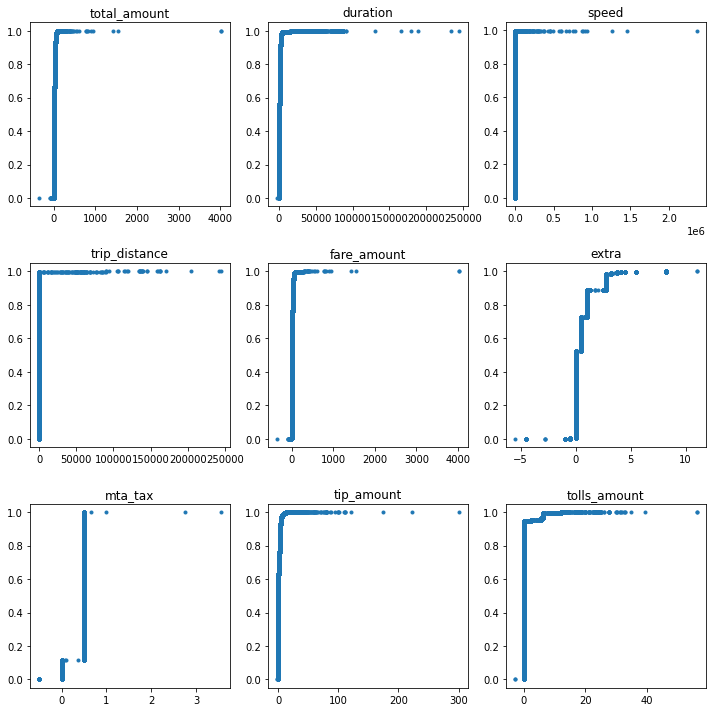

In [ ]:
# select columns want ot make plot
col = ["total_amount", "duration", "speed", "trip_distance", 
       "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount"]

# Compute ECDF for a one-dimensional array of measurements
def ecdf(data):
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

# Plotting Empirical cumulative distribution functions
plt.figure(figsize = (10,10))
nrow = 3
ncol = 3
i = 1 
for val in sample_pd[col]:
    x, y = ecdf(sample_pd[val])
    plt.subplot(nrow, ncol, i)
    ax = plt.plot(x, y, marker='.', linestyle= 'none')
    plt.title(val)
    i += 1
plt.tight_layout()
plt.show();

In [ ]:
# Create table include essencial cutoff
cutoff = pd.DataFrame()

cutoff['Q1'] = sample_pd[col].quantile(0.25)
cutoff['Q3'] = sample_pd[col].quantile(0.75)

cutoff['lower'] = cutoff['Q1'] - 1.5 * (cutoff['Q3'] - cutoff['Q1'])
cutoff['upper'] = cutoff['Q3'] + 1.5 * (cutoff['Q3'] - cutoff['Q1'])


cutoff['0.01'] = sample_pd[col].quantile(0.01)
cutoff['0.99'] = sample_pd[col].quantile(0.99)

cutoff['0.005'] = sample_pd[col].quantile(0.005)
cutoff['0.995'] = sample_pd[col].quantile(0.995)
# Show table round to 2 decimal
cutoff.round(2)

,Q1,Q3,lower,upper,0.01,0.99,0.005,0.995
total_amount,8.80,23.16,-12.74,44.70,3.3,69.92,0.0,78.50
duration,420.00,1249.00,-823.50,2492.50,12.0,4560.00,4.0,7224.42
speed,8.47,14.49,-0.55,23.51,0.0,34.41,0.0,39.15
trip_distance,1.09,4.21,-3.59,8.89,0.0,20.56,0.0,23.63
fare_amount,7.00,19.50,-11.75,38.25,2.5,62.15,0.0,71.20
extra,0.00,1.00,-1.50,2.50,0.0,3.25,0.0,4.50
mta_tax,0.50,0.50,0.50,0.50,0.0,0.50,0.0,0.50
tip_amount,0.00,1.86,-2.79,4.65,0.0,8.00,0.0,10.00
tolls_amount,0.00,0.00,0.00,0.00,0.0,6.12,0.0,6.55


##### [4.2.2] yellow taxi data

###### [4.2.2.1] summary table

In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow"
df_yellow =  spark.read.parquet(path).cache()

# Print the summary of df_yellow
display(df_yellow.summary())

summary,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,taxi_color,file_date
count,122158021,122158021,124048218,122158021,122158021,124048218,124048218,122158021,124048218,124048218,124048218,124048218,124048218,124048218,124048218,119192237,124048218,124048218
mean,1.654580594425314,1.5282874057037974,3.5441557720828434,1.0569145926160672,null,163.59290067351068,161.43926956693565,1.2839407901016995,13.155026697672007,1.0788757916094465,0.4980228986441319,2.166773552500592,0.359293079472701,0.29821600153881633,18.94011812773953,2.195042821454891,null,null
stddev,0.4891042143468908,1.173032188769015,274.95952777784424,0.7605762928215885,null,66.28521497602826,70.50734391242351,0.48008657527752585,195.39007220234532,44.90991817363119,44.892653192481184,12.998831452236713,1.7580345843705332,0.03180878425337303,220.51309236348516,0.8340264839211989,null,null
min,1,0,-37264.53,1,N,1,1,1,-1856.0,-60.0,-0.5,-493.22,-70.0,-0.3,-1871.8,-2.5,yellow,2019-01
25%,1.0,1,1.0,1.0,null,116.0,107.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.16,2.5,null,null
50%,2.0,1,1.66,1.0,null,162.0,162.0,1.0,9.5,0.5,0.5,1.86,0.0,0.3,14.63,2.5,null,null
75%,2.0,2,3.07,1.0,null,234.0,234.0,2.0,14.5,2.5,0.5,2.86,0.0,0.3,20.33,2.5,null,null
max,4,9,350914.88,99,Y,99,99,5,998310.0,500000.8,500000.5,141492.02,3288.0,1.0,1084772.1,4.5,yellow,2021-07


In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow"
df_yellow =  spark.read.parquet(path).cache()

# Get distinct value for each columns
counts_summary = df_yellow.agg(*[countDistinct(c).alias(c) for c in df_yellow.columns]).toPandas()
counts = pd.Series(counts_summary.values.ravel())
counts.index = counts_summary.columns

count_table = counts.sort_values(ascending = False)
print(count_table)

print("cols > 500 distinct value:", list((count_table[count_table > 500]).index))

dropoff_datetime         46727578
pickup_datetime          46713234
total_amount                28160
fare_amount                 14129
trip_distance               11761
tip_amount                   8087
tolls_amount                 3935
extra                         518
PULocationID                  264
DOLocationID                  264
mta_tax                        76
file_date                      31
congestion_surcharge           16
passenger_count                10
RatecodeID                      7
improvement_surcharge           6
payment_type                    5
VendorID                        3
store_and_fwd_flag              2
taxi_color                      1
dtype: int64
cols > 500 distinct value: ['dropoff_datetime', 'pickup_datetime', 'total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount', 'extra']


###### [4.2.2.2] missing value

In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow"
df_yellow =  spark.read.parquet(path).cache()

# Find missing value in df_green
null_summary = df_yellow.select([count(when(col(c).isNull(),c)).alias(c) for c in df_yellow.columns]).toPandas()

null = pd.Series(null_summary.values.ravel())
null.index = null_summary.columns

null_table = null[null != 0].sort_values(ascending = False)
print(null_table)

# "VendorID", "store_and_fwd_flag", "RatecodeID", "payment_type", "passenger_count" all same null value
print()
print("'VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count' all have 1191314 null value")
data = df_yellow.filter((col("VendorID").isNull()) & (col("passenger_count").isNull()) & (col("RatecodeID").isNull()) & (col("store_and_fwd_flag").isNull()) & (col("payment_type").isNull()))
print ("percentage of null in total:", "{:.2f}".format(100*data.count()/df_yellow.count()),"%")

data = data.filter(date_format("file_date", 'yyyy') == 2021)
data_2021 = df_yellow.filter(date_format("file_date", 'yyyy') == 2021)
print ("percentage of null in 2021:", "{:.2f}".format(100*data.count()/data_2021.count()),"%")

congestion_surcharge    4855981
VendorID                1890197
passenger_count         1890197
RatecodeID              1890197
store_and_fwd_flag      1890197
payment_type            1890197
dtype: int64

'VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count' all have 1191314 null value
percentage of null in total: 1.52 %
percentage of null in 2021: 5.56 %


###### [4.2.2.3] distribution

In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow/"
df_yellow =  spark.read.parquet(path).cache()

# Create Sample dataframe
path = "/newyork-taxi/sample/df_sample"
dbutils.fs.rm(path, True)
guessedFraction = 0.01
df_sample_yellow = df_yellow.sample(True, 0.01, 1)
  
# Print the number of rows
print("Number of rows:", df_sample_yellow.count())

# Save as parquet file
path = f"/newyork-taxi/df_sample_yellow"
dbutils.fs.rm(path, True)
df_sample_yellow.write.parquet(path, mode='append')

Number of rows: 1239716


In [ ]:
# Read dataset
path = "/newyork-taxi/df_sample_yellow/"
df_sample_yellow =  spark.read.parquet(path).cache()

# convert sample dataframe to pd dataframe for visualization
sample_pd = df_sample_yellow.toPandas()

## Test to create new variable: 
# duration, in second
sample_pd['duration'] = (sample_pd['dropoff_datetime'] - sample_pd['pickup_datetime']).dt.total_seconds()

# speed, in miles/h
sample_pd['speed'] = sample_pd['trip_distance'] / (sample_pd['duration']/60/60)

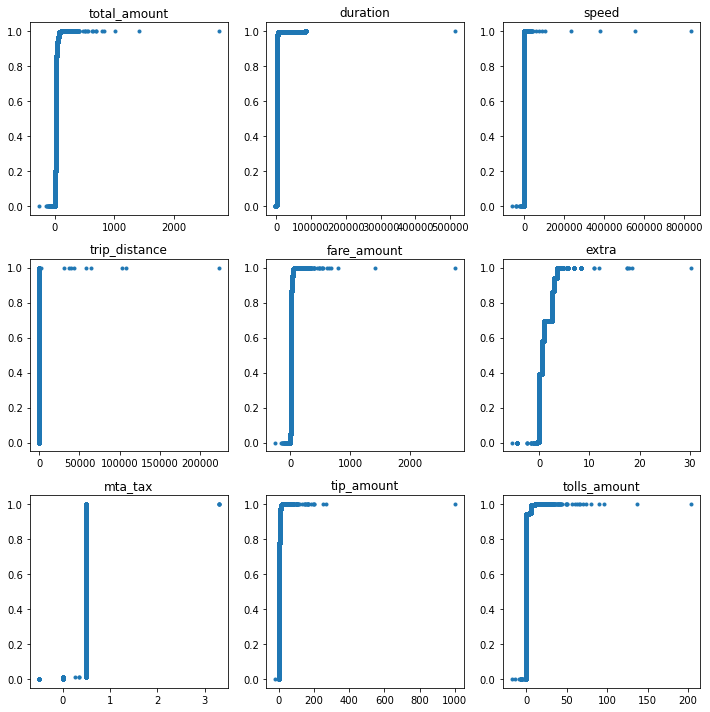

In [ ]:
# select columns want ot make plot
col = ["total_amount", "duration", "speed", "trip_distance", 
       "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount"]

# Compute ECDF for a one-dimensional array of measurements
def ecdf(data):
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

# Plotting Empirical cumulative distribution functions
plt.figure(figsize = (10,10))
nrow = 3
ncol = 3
i = 1 
for val in sample_pd[col]:
    x, y = ecdf(sample_pd[val])
    plt.subplot(nrow, ncol, i)
    ax = plt.plot(x, y, marker='.', linestyle= 'none')
    plt.title(val)
    i += 1
plt.tight_layout()
plt.show();

In [ ]:
# Create table include essencial cutoff
cutoff = pd.DataFrame()

cutoff['Q1'] = sample_pd[col].quantile(0.25)
cutoff['Q3'] = sample_pd[col].quantile(0.75)

cutoff['lower'] = cutoff['Q1'] - 1.5 * (cutoff['Q3'] - cutoff['Q1'])
cutoff['upper'] = cutoff['Q3'] + 1.5 * (cutoff['Q3'] - cutoff['Q1'])


cutoff['0.01'] = sample_pd[col].quantile(0.01)
cutoff['0.99'] = sample_pd[col].quantile(0.99)

cutoff['0.005'] = sample_pd[col].quantile(0.005)
cutoff['0.995'] = sample_pd[col].quantile(0.995)

# Show table round to 2 decimal
cutoff.round(2)

,Q1,Q3,lower,upper,0.01,0.99,0.005,0.995
total_amount,11.16,20.30,-2.55,34.01,5.30,73.92,3.8,80.00
duration,392.00,1076.00,-634.00,2102.00,51.00,3667.00,10.0,4517.43
speed,7.52,13.76,-1.83,23.11,0.03,35.79,0.0,40.16
trip_distance,1.00,3.06,-2.09,6.15,0.00,19.20,0.0,20.90
fare_amount,6.50,14.50,-5.50,26.50,3.00,52.50,2.5,64.50
extra,0.00,2.50,-3.75,6.25,0.00,3.50,0.0,3.75
mta_tax,0.50,0.50,0.50,0.50,0.50,0.50,0.0,0.50
tip_amount,0.00,2.86,-4.29,7.15,0.00,12.28,0.0,14.64
tolls_amount,0.00,0.00,0.00,0.00,0.00,6.12,0.0,6.55


#### [4.3] Clean data

##### [4.3.1] Define function

In [ ]:
# Define function for data cleaning
def clean(df, color, df_new):


    ## Step 1: Drop duplicate
    df = df.dropDuplicates()


    ## Step 2: Clean base on dictionary 
    ## Administrative features:
    # VendorID: should be 1 and 2 base on dictionary
    df = df.filter((F.col("VendorID").isin(list(range(1, 3)))) | (F.col("VendorID").isNull()))

    # RatecodeID: should be int in range 1 to 6 base on dictionary
    df = df.filter((F.col("RatecodeID").isin(list(range(1, 7)))) | (F.col("RatecodeID").isNull()))       
 
    # store_and_fwd_flag: do nothing


    ## Trip features:
    # pickup_datetime & dropoff_datetime: 
    # Assume pickup_datetime's year month must be the same as file_date 
    # and dropoff_datetime must be larger or equal to file_date. 
    df = df.filter(F.date_format("pickup_datetime", 'yyyy-MM') == F.col("file_date")) \
            .filter(F.date_format("dropoff_datetime", 'yyyy-MM') >= F.col("file_date")) 

    # PULocationID: should be int in range 1 to 263 base on dictionary
    if color == "yellow":
        df = df.filter(F.col("PULocationID").isin(list(range(1, 264)))) 

    elif color == "green":
        # Get taxi_zone_lookup table
        url = "https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv"
        spark.sparkContext.addFile(url)
        df_zone = spark.read.csv("file://"+SparkFiles.get("taxi+_zone_lookup.csv"), header=True, inferSchema= True)

        # Get zone that green taxi can pickup passenger
        zone = df_zone.select('LocationID') \
            .filter(F.col("service_zone") == "Boro Zone") \
            .rdd.flatMap(lambda x: x).collect()
        # Clean data
        df = df.filter(F.col("PULocationID").isin(zone)) 

    # DOLocationID: should be int in range 1 to 263 base on dictionary
    df = df.filter(F.col("DOLocationID").isin(list(range(1, 264))))   
    
    # passenger_count: should be int in range 1 to 6 by law restrict
    df = df.filter((F.col("passenger_count").isin(list(range(1, 7)))) | (F.col("passenger_count").isNull()))      

    # trip_type: yellow taxi data do not include trip_type column

    # trip_distance: in mile, should not be negative
    df = df.filter(F.col("trip_distance") > 0)         


    ## Payment features:
    # payment_type: should be int in range 1 to 6 by law restrict
    df = df.filter((F.col("payment_type").isin(list(range(1, 7)))) | (F.col("payment_type").isNull()))      

    # fare_amount: should not smaller than 2.5, as $2.50 is initial charge
    df = df.filter(F.col("fare_amount") >= 2.5)  

    # extra: should be positive
    df = df.filter(F.col("extra") >= 0)          

    # mta_tax: should be 0 or 0.5
    df = df.filter(F.col("mta_tax").isin(0, 0.5))          

    # store_and_fwd_flag: not cleaning  

    # improvement_surcharge: all should have same value 0.3 base on dictionary, drop        
    df = df.drop("improvement_surcharge")
                                    
    # tip_amount: should not be neagative    
    df = df.filter(((F.col("tip_amount") >= 0) & (F.col("payment_type") == "1")) 
                  | ((F.col("tip_amount") == 0) & (F.col("payment_type") != "1")))
   
    # tolls_amount: should not be neagative 
    df = df.filter(F.col("tolls_amount") >= 0)    

    # total_amount: should not less than 2.5, as $2.50 is initial charge
    df = df.filter(F.col("total_amount") >= 2.5) 
                                    
    # congestion_surcharge: 
    # yellow taxi data should be 0 or 2.5 base on dictionary
    if color == "yellow":
        max_value = 2.5
    # green taxi data should be 0 or 2.75 base on dictionary 
    elif color == "green":
        max_value = 2.75

    df = df.filter((F.col("congestion_surcharge").isin(0, max_value)) | (F.col("congestion_surcharge").isNull()))


    # ehail_fee: do nothing


    ## Step 3: Create 2 essencial features
    # duration: in second
    df = df.withColumn("duration", (F.col("dropoff_datetime").cast("long") - F.col("pickup_datetime").cast("long")))

    # speed: in mile/hour, 1 mile = 1.61 km
    df = df.withColumn("speed", (F.col("trip_distance")/(F.col("duration")/60/60)))


    ## Step 4: Clean outlier base on assumption 
    # pickup_datetime should smaller than dropoff_datetime
    df = df.filter(F.col("pickup_datetime") < F.col("dropoff_datetime"))
    
    # fare_amount should around 2.5 + 0.5 * duration, set cutoff
    # when car in low speed, fare_amount = 2.5 + 0.5 * duration
    df = df.filter((F.col("fare_amount") >= 0.5 * (2.5 + 0.5 * (F.col("duration") / 60))) 
                & (F.col("fare_amount") <= 1.5 * (2.5 + 0.5 * (F.col("duration") / 60)))) 

    # payment features
    if color == "yellow":
        df = df.filter((F.col("total_amount") >= 5.3) & (F.col("total_amount") <= 74.70))
        df = df.filter((F.col("duration") >= 56) & (F.col("duration") <= 3749))
        df = df.filter((F.col("speed") >= 0.14) & (F.col("speed") <= 35.36))
        df = df.filter((F.col("trip_distance") >= 0.02) & (F.col("trip_distance") <= 19.2))
        df = df.filter((F.col("fare_amount") >= 3) & (F.col("fare_amount") <= 52))
        df = df.filter((F.col("extra") >= 0) & (F.col("extra") <= 3.5))
        df = df.filter((F.col("mta_tax") >= 0.5) & (F.col("mta_tax") <= 0.5))
        df = df.filter((F.col("tip_amount") >= 0) & (F.col("tip_amount") <= 12.28))
        df = df.filter((F.col("tolls_amount") >= 0) & (F.col("tolls_amount") <= 6.12))
    elif color == "green":
        df = df.filter((F.col("total_amount") >= 3.3) & (F.col("total_amount") <= 69.92))
        df = df.filter((F.col("duration") >= 12) & (F.col("duration") <= 4560))
        df = df.filter((F.col("speed") >= 0) & (F.col("speed") <= 34.41))
        df = df.filter((F.col("trip_distance") >= 0) & (F.col("trip_distance") <= 20.56))
        df = df.filter((F.col("fare_amount") >= 2.5) & (F.col("fare_amount") <= 62.15))
        df = df.filter((F.col("extra") >= 0) & (F.col("extra") <= 3.25))
        df = df.filter((F.col("mta_tax") >= 0) & (F.col("mta_tax") <= 0.5))
        df = df.filter((F.col("tip_amount") >= 0) & (F.col("tip_amount") <= 8))
        df = df.filter((F.col("tolls_amount") >= 0) & (F.col("tolls_amount") <= 6.12))
               
#     # Or use
#     # Set limit to payment features
#     cols = ["total_amount", "duration", "speed", "trip_distance", 
#        "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount"]
#     for col in cols:
#         cutoff = df.approxQuantile(col, [0.01, 0.99], 0)
#         lower = cutoff[0]
#         upper = cutoff[1]
#         df = df.filter((F.col(col) >= lower) & (F.col(col) <= upper))
   

    ## Step 5: Fill missing
    cols = df.columns
    for col in cols:
        df = df.withColumn(col, when(F.col(col).isNull(), "missing").otherwise(F.col(col)))
    

    ## Save df as parquet file
    path = f"/newyork-taxi/{df_new}"
    dbutils.fs.rm(path, True)
    df.write.parquet(path, mode='append')

##### [4.3.2] Clean sample data to test

In [ ]:
# Clean data
clean(df_sample_yellow, "yellow", "df_sample_yellow_clean")

# Read data df_yellow_clean
path = "/newyork-taxi/df_sample_yellow_clean"
df_sample_yellow_clean =  spark.read.parquet(path)

# Number of rows
print ("Percentage of rows dropped:", "{:.2f}".format(100*(df_sample_yellow.count() - df_sample_yellow_clean.count())/df_sample_yellow.count()), "%")

Percentage of rows dropped: 19.25 %


In [ ]:
# Clean data
clean(df_sample_green, "green", "df_sample_green_clean")

# Read data df_green_clean
path = "/newyork-taxi/df_sample_green_clean"
df_sample_green_clean =  spark.read.parquet(path)

# Number of rows
print ("Percentage of rows dropped:", "{:.2f}".format(100*(df_sample_green.count() - df_sample_green_clean.count())/df_sample_green.count()), "%")

Percentage of rows dropped: 36.02 %


##### [4.3.3] Clean yellow taxi data

In [ ]:
# Read dataset for yellow taxi data
path = "/newyork-taxi/df_yellow"
df_yellow =  spark.read.parquet(path).cache()

# Clean data
clean(df_yellow, "yellow", "df_yellow_clean")

# Read data df_yellow_clean
path = "/newyork-taxi/df_yellow_clean"
df_yellow_clean =  spark.read.parquet(path)

# Number of rows dropped
print ("Percentage of rows dropped:", "{:.2f}".format(100*(df_yellow.count() - df_yellow_clean.count())/df_yellow.count()), "%")

Percentage of rows dropped: 18.87 %


##### [4.3.4] Clean green taxi data

In [ ]:
# Read dataset for green taxi data
path = "/newyork-taxi/df_green/"
df_green =  spark.read.parquet(path).cache()

# Clean data
clean(df_green, "green" , "df_green_clean")

# Read data df_green_clean
path = "/newyork-taxi/df_green_clean"
df_green_clean =  spark.read.parquet(path)

# Number of rows dropped
print ("Percentage of rows dropped:", "{:.2f}".format(100*(df_green.count() - df_green_clean.count())/df_green.count()), "%")

Percentage of rows dropped: 32.71 %


### 5. Combine dataset

In [ ]:
# Get dataset for green taxi data
path = "/newyork-taxi/df_green_clean/"
df_green_clean =  spark.read.parquet(path).cache()

# Read dataset for yellow taxi data
# Add columns appeard in df_green: ehail_fee and trip_type
path = "/newyork-taxi/df_yellow_clean"
df_yellow_clean =  spark.read.parquet(path) \
    .withColumn("ehail_fee", F.lit(0.0).cast(FloatType())) \
    .withColumn("trip_type", F.lit("no").cast(StringType())) \
    .cache()

# don't include improvement_surcharge
list_of_column = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 
    'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count',
    'trip_type', 'trip_distance', 'duration', 'speed', 'payment_type',
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'total_amount', 'congestion_surcharge', 'ehail_fee',
    'taxi_color']

# Reorder dataframes: df_green
df_green_clean = df_green_clean.select(list_of_column)

# Reorder dataframes: df_yellow
df_yellow_clean = df_yellow_clean.select(list_of_column)

# Merge both data
df_all = df_yellow_clean.union(df_green_clean)

# change numeric as float tyoe
cols = ['total_amount', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'duration', 'speed']

for col in cols:
    df_all = df_all.withColumn(col, F.col(col).cast("float").alias(col)) 
    
## Save df_green_clean as parquet file
path = "/newyork-taxi/df_all"
dbutils.fs.rm(path, True)
df_all.write.parquet(path, mode='append')

In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

print("Number of rows:", df_all.count())

Number of rows: 106262678


In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Print the summary table
display(df_all.summary())

summary,VendorID,RatecodeID,store_and_fwd_flag,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_type,trip_distance,duration,speed,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,ehail_fee,taxi_color
count,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678,106262678
mean,1.669582917908393,1.0054133117179673,null,null,null,162.3022870362819,161.76005597186247,1.546957662783541,1.0199698511856232,1.8583277517106194,713.5816294974234,9.901660129060216,1.2800804907250691,9.794503044069298,1.0410008477284487,0.49979206716397645,1.7238581473342571,0.03183993321852396,14.811979136310464,2.226144055003329,5.8124971869003996E-8,null
stddev,0.47036330217790356,0.14690557187981101,null,null,null,67.84976496737406,69.74094894930978,1.1589542325384035,0.13989660365145373,1.407969846961796,488.0899731568654,3.661198536060818,0.4624855311378066,5.2471341199534205,1.1984327432770998,0.01019427206452127,1.555820166442175,0.43704999901962654,6.33978166446633,0.7835944246240059,3.366655504981408E-4,null
min,1,1,N,2019-01-01 00:00:01,2019-01-01 00:02:47,1,1,1,1,0.01,12.0,0.008928571,1,2.5,0.0,0.0,0.0,0.0,3.31,0.0,0.0,green
25%,1.0,1.0,null,null,null,113.0,107.0,1.0,1.0,0.93,371.0,7.315508,1.0,6.0,0.0,0.5,0.0,0.0,10.56,2.5,0.0,null
50%,2.0,1.0,null,null,null,162.0,162.0,1.0,1.0,1.48,592.0,9.520661,1.0,8.5,0.5,0.5,1.76,0.0,13.5,2.5,0.0,null
75%,2.0,1.0,null,null,null,234.0,234.0,2.0,1.0,2.32,918.0,12.065934,2.0,12.0,2.5,0.5,2.65,0.0,17.3,2.5,0.0,null
max,2,6,Y,2021-07-31 23:59:55,2021-08-01 00:39:17,99,99,6,no,20.55,4560.0,35.357143,5,60.5,3.5,0.5,12.28,6.12,73.25,missing,missing,yellow


In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Find missing value in df_green
null_summary = df_all.select([count(when(col(c).isNull(),c)).alias(c) for c in df_all.columns]).toPandas()

null = pd.Series(null_summary.values.ravel())
null.index = null_summary.columns

null_table = null[null != 0].sort_values(ascending = False)
print(null_table)

Series([], dtype: int64)


In [ ]:
# Export file
file_name = "df_all"
path = "dbfs:/FileStore/df/" + file_name
dbutils.fs.rm(path, True)
df_all.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").option("delimiter", "\t").option("compression", "gzip").save(path)

## PART 2: Business Questions

In [ ]:
# Get dataset for green taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Get view
df_all.createOrReplaceTempView("df_view")

### 1. For each year and month:

#### a. What was the total number of trips?

In [ ]:
spark.sql('''
SELECT 
YEAR(pickup_datetime) as year, 
MONTH(pickup_datetime) as month, 
COUNT(*) trips
FROM df_view
GROUP BY year, month
ORDER BY year, trips DESC
'''
).show(31)

# most months in 2019 have higher trips than other.

+----+-----+-------+
|year|month|  trips|
+----+-----+-------+
|2019|    3|6939892|
|2019|    5|6662514|
|2019|    1|6615889|
|2019|    4|6541435|
|2019|   10|6276640|
|2019|    2|6253296|
|2019|    6|6073976|
|2019|   11|5995397|
|2019|   12|5970952|
|2019|    9|5702567|
|2019|    7|5451857|
|2019|    8|5190651|
|2020|    1|5499640|
|2020|    2|5483463|
|2020|    3|2579394|
|2020|   10|1381311|
|2020|   11|1233811|
|2020|   12|1196946|
|2020|    9|1080562|
|2020|    8| 781949|
|2020|    7| 605052|
|2020|    6| 406707|
|2020|    5| 232673|
|2020|    4| 171206|
|2021|    6|2267143|
|2021|    7|2186331|
|2021|    5|2005637|
|2021|    4|1740399|
|2021|    3|1548578|
|2021|    2|1103338|
|2021|    1|1083472|
+----+-----+-------+



#### b. Which day of week (e.g. monday, tuesday, etc..) had the most trips?

In [ ]:
# The WEEKDAY() function returns the weekday number for a given date.
# Note: 0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday.
spark.sql('''
WITH CTE AS
(
    SELECT
    YEAR(pickup_datetime) AS year
    , MONTH(pickup_datetime) AS month
    , WEEKDAY(pickup_datetime) AS day_of_week
    , COUNT(*) AS trips
    FROM df_view
    GROUP BY year, month, day_of_week
)
SELECT year, month,
    CASE 
        WHEN day_of_week = 0 THEN 'Monday'
        WHEN day_of_week = 1 THEN 'Tuesday'
        WHEN day_of_week = 2 THEN 'Wednesday'
        WHEN day_of_week = 3 THEN 'Thursday'
        WHEN day_of_week = 4 THEN 'Friday'
        WHEN day_of_week = 5 THEN 'Saturday'
        WHEN day_of_week = 6 THEN 'Sunday'
    END AS week
, trips 
FROM (
    SELECT 
    year
    , month
    , day_of_week
    , trips
    , RANK() OVER(Partition BY year, month ORDER BY trips DESC) AS RK
    FROM CTE
)d
WHERE d.RK = 1
ORDER BY year, trips DESC
'''
).show(31)

# Thursday and Friday are in top 4 weekdays in each year.

+----+-----+---------+-------+
|year|month|     week|  trips|
+----+-----+---------+-------+
|2019|    3|   Friday|1243533|
|2019|    5| Thursday|1185156|
|2019|    1| Thursday|1183105|
|2019|   10| Thursday|1113678|
|2019|    4|  Tuesday|1111263|
|2019|   11|   Friday|1071777|
|2019|    6| Saturday| 998572|
|2019|    2|   Friday| 994754|
|2019|    7|Wednesday| 988731|
|2019|    8| Thursday| 953830|
|2019|   12|  Tuesday| 949736|
|2019|    9| Thursday| 875106|
|2020|    1|   Friday| 980222|
|2020|    2| Saturday| 946637|
|2020|    3|  Tuesday| 412072|
|2020|   10| Thursday| 259158|
|2020|   12|  Tuesday| 226824|
|2020|   11|   Monday| 210191|
|2020|    9|Wednesday| 206618|
|2020|    8|   Monday| 131279|
|2020|    7| Thursday| 116184|
|2020|    6|  Tuesday|  77249|
|2020|    5|   Friday|  46412|
|2020|    4| Thursday|  31761|
|2021|    6|Wednesday| 409038|
|2021|    7| Thursday| 397020|
|2021|    4|   Friday| 330908|
|2021|    5| Saturday| 326084|
|2021|    3|Wednesday| 273903|
|2021|  

#### c. Which hour of the day had the most trips?

In [ ]:
spark.sql('''
WITH CTE AS
(
    SELECT
    YEAR(pickup_datetime) AS year
    , MONTH(pickup_datetime) AS month
    , HOUR(pickup_datetime) AS hour
    , COUNT(*) AS trips
    FROM df_view
    GROUP BY year, month, hour
    
)
SELECT year, month, hour, trips 
FROM (
    SELECT 
    year
    , month
    , hour
    , trips
    , RANK() OVER(Partition BY year, month ORDER BY trips DESC) AS RK
    FROM CTE
)d
WHERE d.RK = 1
ORDER BY year, trips DESC
'''
).show(31)

# 17 months has the highest number of trips at hour 18. 
# 14 months has the highest number of trips at hour 15. 

+----+-----+----+------+
|year|month|hour| trips|
+----+-----+----+------+
|2019|    3|  18|482525|
|2019|    1|  18|473082|
|2019|    5|  18|467390|
|2019|    4|  18|463174|
|2019|   10|  18|445519|
|2019|    2|  18|445427|
|2019|   11|  18|419653|
|2019|    6|  18|403916|
|2019|   12|  18|402349|
|2019|    9|  18|398942|
|2019|    7|  18|376120|
|2019|    8|  18|358535|
|2020|    2|  18|404368|
|2020|    1|  18|398393|
|2020|    3|  18|189107|
|2020|   10|  15|107561|
|2020|   12|  15|106066|
|2020|   11|  15|102982|
|2020|    9|  15| 84802|
|2020|    8|  15| 61539|
|2020|    7|  15| 47929|
|2020|    6|  15| 33171|
|2020|    5|  15| 18842|
|2020|    4|  15| 13306|
|2021|    6|  18|171102|
|2021|    7|  18|170725|
|2021|    5|  18|154546|
|2021|    4|  15|137632|
|2021|    3|  15|124896|
|2021|    1|  15| 94318|
|2021|    2|  15| 91391|
+----+-----+----+------+



#### d. What was the average number of passengers?

In [ ]:
# round in 0 decimal places
spark.sql('''
SELECT 
YEAR(pickup_datetime) AS year
, MONTH(pickup_datetime) AS month
, ROUND(AVG(passenger_count), 0) AS avg_passengers
FROM df_view
GROUP BY year, month
Order by year, avg_passengers DESC
'''
).show(31)

+----+-----+--------------+
|year|month|avg_passengers|
+----+-----+--------------+
|2019|    5|           2.0|
|2019|    4|           2.0|
|2019|    8|           2.0|
|2019|    9|           2.0|
|2019|   12|           2.0|
|2019|    6|           2.0|
|2019|    7|           2.0|
|2019|   11|           2.0|
|2019|    3|           2.0|
|2019|    1|           2.0|
|2019|    2|           2.0|
|2019|   10|           2.0|
|2020|    1|           2.0|
|2020|    2|           2.0|
|2020|   11|           1.0|
|2020|    3|           1.0|
|2020|    4|           1.0|
|2020|    9|           1.0|
|2020|    8|           1.0|
|2020|    7|           1.0|
|2020|    6|           1.0|
|2020|   12|           1.0|
|2020|   10|           1.0|
|2020|    5|           1.0|
|2021|    6|           1.0|
|2021|    5|           1.0|
|2021|    7|           1.0|
|2021|    3|           1.0|
|2021|    2|           1.0|
|2021|    1|           1.0|
|2021|    4|           1.0|
+----+-----+--------------+



#### e. What was the average amount paid per trip (using total_amount)?

In [ ]:
spark.sql('''
SELECT 
YEAR(pickup_datetime) AS year
, MONTH(pickup_datetime) AS month
, ROUND(AVG(total_amount), 2) AS avg_amount
FROM df_view
GROUP BY year, month
ORDER BY year, avg_amount DESC
''').show(31)

+----+-----+----------+
|year|month|avg_amount|
+----+-----+----------+
|2019|   10|     15.57|
|2019|    9|     15.53|
|2019|    5|     15.45|
|2019|    6|     15.44|
|2019|   12|     15.41|
|2019|   11|     15.41|
|2019|    4|     15.11|
|2019|    7|     15.06|
|2019|    3|     14.98|
|2019|    8|     14.87|
|2019|    2|     14.68|
|2019|    1|     11.94|
|2020|    2|      14.8|
|2020|    3|     14.61|
|2020|    1|     14.49|
|2020|   10|     14.48|
|2020|    9|     14.32|
|2020|   11|      14.3|
|2020|   12|     14.24|
|2020|    8|     13.92|
|2020|    7|     13.75|
|2020|    6|     13.52|
|2020|    5|     12.56|
|2020|    4|     11.93|
|2021|    6|     15.22|
|2021|    7|     14.95|
|2021|    5|     14.83|
|2021|    4|     14.64|
|2021|    3|     14.34|
|2021|    2|      14.3|
|2021|    1|     13.74|
+----+-----+----------+



#### f. What was the average amount paid per passenger (using total_amount)?

In [ ]:
spark.sql('''
SELECT 
YEAR(pickup_datetime) AS year
, MONTH(pickup_datetime) AS month
, ROUND(AVG(total_amount/passenger_count), 2) AS avg_amount_pass
FROM df_view
GROUP BY year, month
ORDER BY year, avg_amount_pass DESC
''').show(31)

+----+-----+---------------+
|year|month|avg_amount_pass|
+----+-----+---------------+
|2019|   10|          12.94|
|2019|    9|          12.89|
|2019|   11|          12.78|
|2019|    5|          12.76|
|2019|    6|          12.75|
|2019|   12|          12.72|
|2019|    4|          12.49|
|2019|    7|          12.44|
|2019|    3|          12.38|
|2019|    8|          12.26|
|2019|    2|          12.16|
|2019|    1|           9.93|
|2020|   10|          12.44|
|2020|    3|          12.43|
|2020|    2|          12.42|
|2020|   11|          12.33|
|2020|    9|          12.31|
|2020|   12|          12.28|
|2020|    1|          12.14|
|2020|    8|          12.02|
|2020|    7|          11.98|
|2020|    6|          11.89|
|2020|    5|           11.2|
|2020|    4|          10.78|
|2021|    6|          12.92|
|2021|    5|          12.67|
|2021|    4|          12.61|
|2021|    7|          12.58|
|2021|    3|          12.39|
|2021|    2|          12.37|
|2021|    1|           11.9|
+----+-----+--

### 2. For each taxi colour (yellow and green):

#### a. What was the average, median, minimum and maximum trip duration in seconds?

In [ ]:
spark.sql('''
WITH CTE AS
(
    SELECT 
    taxi_color
    , DATEDIFF(second, pickup_datetime, dropoff_datetime) AS duration
    FROM df_view
)
SELECT 
taxi_color
, ROUND(AVG(duration), 2) AS avg_duration
, approx_percentile(duration, 0.5, 100) AS med_duration
, MIN(duration) AS min_duration
, MAX(duration) AS max_duration
FROM CTE
GROUP BY taxi_color
''').show()

+----------+------------+------------+------------+------------+
|taxi_color|avg_duration|med_duration|min_duration|max_duration|
+----------+------------+------------+------------+------------+
|    yellow|      711.61|         590|          56|        3749|
|     green|      748.85|         593|          12|        4560|
+----------+------------+------------+------------+------------+



#### b. What was the average, median, minimum and maximum trip distance in km?

In [ ]:
# 1 mile = 1.61 kilometre, round to 2 decimal places
spark.sql('''
SELECT
taxi_color
, ROUND(AVG(trip_distance * 1.61), 2) AS avg_distance 
, ROUND(approx_percentile(trip_distance * 1.61, 0.5, 100), 2) AS med_distance
, ROUND(MIN(trip_distance * 1.61), 2) AS min_distance
, ROUND(MAX(trip_distance * 1.61), 2) AS max_distance
FROM df_view
GROUP BY taxi_color
''').show()

+----------+------------+------------+------------+------------+
|taxi_color|avg_distance|med_distance|min_distance|max_distance|
+----------+------------+------------+------------+------------+
|    yellow|        2.97|        2.35|        0.05|        30.9|
|     green|         3.4|        2.58|        0.02|       33.09|
+----------+------------+------------+------------+------------+



#### c. What was the average, median, minimum and maximum speed in km per hour?

In [ ]:
spark.sql('''
WITH CTE AS
(
    SELECT 
    taxi_color
    , (trip_distance*1.61)/(duration/60/60) AS speed
    FROM (
        SELECT taxi_color
        , trip_distance
        , DATEDIFF(second, pickup_datetime, dropoff_datetime) AS duration
        FROM df_view
        )
)
SELECT 
taxi_color
, ROUND(AVG(speed), 2) AS avg_speed
, ROUND(approx_percentile(speed, 0.5, 100), 2) AS med_speed
, ROUND(MIN(speed), 2) AS min_speed
, ROUND(MAX(speed), 2) AS max_speed
FROM CTE
GROUP BY taxi_color
''').show()

+----------+---------+---------+---------+---------+
|taxi_color|avg_speed|med_speed|min_speed|max_speed|
+----------+---------+---------+---------+---------+
|    yellow|    15.89|    15.24|     0.23|    56.93|
|     green|    16.81|    16.41|     0.01|    55.33|
+----------+---------+---------+---------+---------+



### 3. What was the percentage of trips where the driver received tips?

In [ ]:
# According to the data dictionary, cash tips are not included in this dataset
# And Tip_amount is automatically populated for credit card tips
# Therefore, Tip_amount should only be valid for records having Payment_type = 1 
# Assuming this question asks the percentage of trips where the driver received tips when the customer is paying by card.

spark.sql('''
SELECT 
ROUND((SELECT count(*) FROM df_view WHERE tip_amount > 0)/ count(*), 4) as perc_with_tips
FROM df_view 
WHERE payment_type = 1
''').show()

+--------------+
|perc_with_tips|
+--------------+
|        0.9593|
+--------------+



### 4. For trips where the driver received tips, what was the percentage where the driver received tips of at least $10.

In [ ]:
# the dataset is assumed tip_amount is reasonable only when payment_type = 1
spark.sql('''
SELECT 
ROUND((SELECT count(*) FROM df_view WHERE tip_amount >= 10)/ count(*), 4) as perc_with_tips
FROM df_view 
WHERE payment_type = 1 AND tip_amount > 0
''').show()

+--------------+
|perc_with_tips|
+--------------+
|        0.0021|
+--------------+



### 5. Classify each trip into bins of durations:
* Under 5 Mins
* From 5 mins to 10 mins
* From 10 mins to 20 mins
* From 20 mins to 30 mins
* At least 30 mins

Then for each bins, calculate:

#### a. Average speed (km per hour)

In [ ]:
spark.sql('''
WITH CTE AS
(
    SELECT trip_distance, duration,
        CASE 
            WHEN duration < 5 THEN "<5"
            WHEN duration >=5 AND duration <10 THEN "5-10"
            WHEN duration >=10 AND duration <20 THEN "10-20"
            WHEN duration >=20 AND duration <30 THEN "20-30"
            WHEN duration >=30 THEN ">30" 
        END as duration_bins
    FROM (
        SELECT trip_distance
        , DATEDIFF(minute, pickup_datetime, dropoff_datetime) AS duration
        FROM df_view
        )
)
SELECT duration_bins
, ROUND(AVG((trip_distance*1.6)/(duration/60)), 2) as average_speed
FROM CTE
GROUP BY duration_bins
ORDER BY average_speed DESC
''').show()

+-------------+-------------+
|duration_bins|average_speed|
+-------------+-------------+
|           <5|         23.2|
|         5-10|        17.31|
|        10-20|        15.28|
|          >30|         14.7|
|        20-30|        14.22|
+-------------+-------------+



#### b. Average distance per dollar (km per $)

In [ ]:
spark.sql('''
WITH CTE AS
(
    SELECT 
    trip_distance, total_amount, 
        CASE 
            WHEN duration < 5 THEN "<5"
            WHEN duration >=5 AND duration <10 THEN "5-10"
            WHEN duration >=10 AND duration <20 THEN "10-20"
            WHEN duration >=20 AND duration <30 THEN "20-30"
            WHEN duration >=30 THEN ">30" 
        END as duration_bins
    FROM (
        SELECT 
        trip_distance
        , total_amount
        , DATEDIFF(minute, pickup_datetime, dropoff_datetime) AS duration
        FROM df_view
        )
)
SELECT duration_bins
, ROUND(AVG((trip_distance*1.6)/(total_amount)), 2) as average_distance_dollar
FROM CTE
GROUP BY duration_bins
ORDER BY average_distance_dollar
''').show()

+-------------+-----------------------+
|duration_bins|average_distance_dollar|
+-------------+-----------------------+
|           <5|                   0.13|
|         5-10|                   0.17|
|        10-20|                   0.21|
|        20-30|                   0.24|
|          >30|                   0.27|
+-------------+-----------------------+



### 6. Which duration bin will you advise a taxi driver to target to maximise his income?

The bin that gives less distance per dollar should be the target In this case, the driver should target the trip's duration of fewer than 5 minutes which on average gets 1 dollar income per 0.12 km.

## PART 3: Machine Learning
Build at least two different ML models using Spark ML pipelines to predict the Total fare amount of a trip:
* Use the 2019 and 2020 data to train and validate your models
* Use the RMSE score to assess your models.
* Choose your best model and explain why you choose it.
* Using your best model, predict the 2021 data.

In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Creating some features
df_all = df_all \
    .withColumn("year", date_format(F.col("pickup_datetime"), 'yyyy')) \
    .withColumn("month", date_format(F.col("pickup_datetime"), 'MM')) \
    .withColumn("weekday", dayofweek(F.col("pickup_datetime"))) \
    .withColumn("hour", hour(F.col("pickup_datetime")))

In [ ]:
len(df_all.columns)

Out[39]: 26

### 1. Feature engineering

#### [1.1] explore more

In [ ]:
# Select all features
cat_cols = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
    'passenger_count', 'trip_type', 'payment_type', 'mta_tax', 'congestion_surcharge', 'ehail_fee', 'taxi_color',
    'year', 'month', 'weekday', 'hour'
]

for i in cat_cols:
    print(i)
    df_all.groupBy(i) \
        .agg(round(mean("total_amount"), 2).alias("average_total_amount"),
             count("total_amount").alias("count")) \
        .orderBy("average_total_amount", ascending = False) \
        .show(10)

VendorID
+--------+--------------------+--------+
|VendorID|average_total_amount|   count|
+--------+--------------------+--------+
|       1|               14.85|35111004|
|       2|               14.79|71151674|
+--------+--------------------+--------+

RatecodeID
+----------+--------------------+---------+
|RatecodeID|average_total_amount|    count|
+----------+--------------------+---------+
|         2|               37.86|      217|
|         5|                21.5|   142771|
|         1|                14.8|106118380|
|         4|               13.68|     1291|
|         6|               11.98|        7|
|         3|                11.8|       12|
+----------+--------------------+---------+

store_and_fwd_flag
+------------------+--------------------+---------+
|store_and_fwd_flag|average_total_amount|    count|
+------------------+--------------------+---------+
|                 Y|               15.07|   842836|
|                 N|               14.81|105419842|
+------------

In [ ]:
# summary statistics of target feature
df_all.select('total_amount').describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|         106262678|
|   mean|14.811979136310464|
| stddev|  6.33978166446633|
|    min|              3.31|
|    max|             73.25|
+-------+------------------+



#### [1.2] Correlation numeric variables

In [ ]:
cols = [
    'total_amount', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'duration', 'speed'
]

# Loading Data 
df = df_all.select(cols).cache()

assembler = VectorAssembler(inputCols=df.columns, outputCol="features",handleInvalid='keep')
df_vector = assembler.transform(df).select("features")

# Correlation will be in Dense Matrix
correlation = Correlation.corr(df_vector,"features","pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation.toArray().tolist()
corr = spark.createDataFrame(rows, cols)

display(corr)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


total_amount,trip_distance,fare_amount,extra,tip_amount,tolls_amount,duration,speed
1.0,0.8884999621137596,0.9525437240356301,0.0722721129401463,0.6311595054379237,0.3465179559348902,0.9242323055264526,-0.029214264850435552
0.8884999621137596,1.0,0.9290827660430845,-0.007699660098075073,0.3928081985776237,0.3166183999170265,0.8331979579051202,0.24908434998188717
0.9525437240356301,0.9290827660430845,1.0,0.006570554188648966,0.41669715937131,0.2831940484289117,0.973412024096502,-0.037373549385339815
0.0722721129401463,-0.007699660098075073,0.006570554188648966,1.0,0.05240974583125473,0.0013547663337826123,0.00929459087971385,-0.042038442703204094
0.6311595054379237,0.3928081985776237,0.41669715937131,0.05240974583125473,1.0,0.17585130314419825,0.39863649918099253,0.0057612977438822755
0.3465179559348902,0.3166183999170265,0.2831940484289117,0.0013547663337826123,0.17585130314419825,1.0,0.24326065051467974,0.052392412257635655
0.9242323055264526,0.8331979579051202,0.973412024096502,0.00929459087971385,0.39863649918099253,0.24326065051467974,1.0,-0.2102205183415775
-0.029214264850435552,0.24908434998188717,-0.037373549385339815,-0.042038442703204094,0.0057612977438822755,0.052392412257635655,-0.2102205183415775,1.0


### 2. Test on all data

##### [2.1] Preperation

In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Creating some features
df_all = df_all \
    .withColumn("year", date_format(F.col("pickup_datetime"), 'yyyy')) \
    .withColumn("month", date_format(F.col("pickup_datetime"), 'MM')) \
    .withColumn("weekday", dayofweek(F.col("pickup_datetime"))) \
    .withColumn("hour", hour(F.col("pickup_datetime")))

# Get data
df = df_all.sample(True, 0.0001, 1)

# Rename target to label
df = df.withColumnRenamed("total_amount", "label")


## Get categorical features
# Create cat_cols that contains categorical features
cat_cols = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
    'passenger_count', 'trip_type', 'payment_type', 'mta_tax', 'ehail_fee', 'taxi_color',
    'year', 'month', 'weekday', 'hour'
]

# Transform categorical features
# stages = []
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in cat_cols]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in cat_cols]

ppl = Pipeline(stages = stage_string + stage_one_hot)
df = ppl.fit(df).transform(df)


# Handling numerical data
# Create a variable called num_cols that contains numerical features
num_cols = [
    'trip_distance', 'duration', 'speed', 'extra', 'tip_amount', 'tolls_amount'
]

va = [VectorAssembler(inputCols=[f], outputCol=(f + '_vec')) for f in num_cols]
scaler = [StandardScaler(inputCol=f + '_vec', outputCol=f + '_scaled', withMean=True, withStd=True) for f in num_cols]

ppl2 = Pipeline(stages= va + scaler)

df = ppl2.fit(df).transform(df)

# Put them together
categoricals = [var for var in df.columns if var.endswith("_one_hot")]
numericals = [var for var in df.columns if var.endswith("_scaled")]
vector_assembler = VectorAssembler(inputCols= categoricals + numericals, outputCol= "features")
df = vector_assembler.transform(df)

# Save data
path = f"/newyork-taxi/model/df_sample"
dbutils.fs.rm(path, True)
df.write.parquet(path, mode='append')

In [ ]:
# Read data df_yellow_clean
path = f"/newyork-taxi/model/df_sample"
df =  spark.read.parquet(path)

# Split data
train = df.filter(F.col("year") ==2019)
validation = df.filter(F.col("year") == 2020)
test = df.filter(F.col("year") == 2021)

print("Percentage of train data:", "{:.2f}".format(100*train.count()/df.count()), "%") 
print("Percentage of validation data:", "{:.2f}".format(100*validation.count()/df.count()), "%") 
print("Percentage of test data:", "{:.2f}".format(100*test.count()/df.count()), "%") 

Percentage of train data: 68.79 %
Percentage of validation data: 19.53 %
Percentage of test data: 11.67 %


##### [2.2] Models

In [ ]:
## Random forest Models
# Instantiate a model
rfr = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Fit the model
model = rfr.fit(train)

# Save model
name = "rfr_all_sample"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)



## Linear Regression
# Get model
lr = LinearRegression(featuresCol="features",\
                      labelCol="label")

# Fit the model                            
model = lr.fit(train)

# Save model
name = "lr_all_sample"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)


## Generalized Linear Regression
# Get model
glr = GeneralizedLinearRegression(family="gaussian", link="identity",\
                                  maxIter=10, regParam=0.3, featuresCol="features",\
                                  labelCol="label")
# Fit the model                
model = glr.fit(train)

# Save model
name = "glr_all_sample"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)



## GBM Models
# Get model 
gbm = GBTRegressor(featuresCol="features", \
                                labelCol="label", \
                                seed=42)
# Fit the model                            
model = gbm.fit(train)

# Save model
name = "gbm_all_sample"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)

##### [2.3] Feature Importance

In [ ]:
# Load model
name = "rfr_all_sample"
path = "/newyork-taxi/model/" + name
model = RandomForestRegressionModel.load(path)

# Feature Importance
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(model.featureImportances, df, "features").head(20)

,idx,name,score
1,381,duration_scaled_0,0.457345
0,380,trip_distance_scaled_0,0.269699
4,384,tip_amount_scaled_0,0.142983
5,385,tolls_amount_scaled_0,0.065496
56,50,PULocationID_one_hot_138,0.019068
338,332,payment_type_one_hot_1,0.012515
2,382,speed_scaled_0,0.011650
339,333,payment_type_one_hot_2,0.005510
346,340,month_one_hot_01,0.002429
79,73,PULocationID_one_hot_132,0.001920


##### [2.4] Performance

In [ ]:
# Load model
name = "rfr_all_sample"
path = "/newyork-taxi/model/" + name
rfr = RandomForestRegressionModel.load(path)

# Load model
name = "lr_all_sample"
path = "/newyork-taxi/model/" + name
lr = LinearRegressionModel.load(path)

# Load model
name = "glr_all_sample"
path = "/newyork-taxi/model/" + name
glr = GeneralizedLinearRegressionModel.load(path)

name = "gbm_all_sample"
path = "/newyork-taxi/model/" + name
gbm = GBTRegressionModel.load(path)

# Make prediction
models = [rfr, lr, glr, gbm]
for model in models:
    print(str(model).split(":")[0])
    predictions_train = model.transform(train)
    predictions_validation = model.transform(validation)

    # Get evaluation metric
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

    data = {'train': predictions_train, 'val  ': predictions_validation}
    for key, preds in data.items():
        # Create evaluation metrics
        rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
        r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})    
        # Print Model Metrics
        print(key, " RMSE =", str(rmse), " R^2 =", str(r2)) 

RandomForestRegressionModel
train  RMSE = 1.6021955981952851  R^2 = 0.9414377932964247
val    RMSE = 1.3542058566139357  R^2 = 0.9410885213930706
LinearRegressionModel
train  RMSE = 0.5212720432872062  R^2 = 0.9938010914150687
val    RMSE = 1.1148459032731455  R^2 = 0.9600735927426767
GeneralizedLinearRegressionModel
train  RMSE = 0.5592276603543218  R^2 = 0.9928654981794262
val    RMSE = 1.101576416901184  R^2 = 0.9610183868491686
GBTRegressionModel
train  RMSE = 1.0962316319368055  R^2 = 0.9725848249166876
val    RMSE = 1.4569923236504203  R^2 = 0.9318061711855228


### 3. Test on 3 features

##### [3.1] Preperation

In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Creating some features
df_all = df_all \
    .withColumn("year", date_format(F.col("pickup_datetime"), 'yyyy')) \
    .withColumn("month", date_format(F.col("pickup_datetime"), 'MM')) \
    .withColumn("weekday", dayofweek(F.col("pickup_datetime"))) \
    .withColumn("hour", hour(F.col("pickup_datetime")))

# Get data
df = df_all.sample(True, 0.0001, 1)

# Rename target to label
df = df.withColumnRenamed("total_amount", "label")


# Handling numerical data

num_cols = [
    'duration', 'trip_distance', 'tip_amount'
]

va = [VectorAssembler(inputCols=[f], outputCol=(f + '_vec')) for f in num_cols]
scaler = [StandardScaler(inputCol=f + '_vec', outputCol=f + '_scaled', withMean=True, withStd=True) for f in num_cols]

ppl2 = Pipeline(stages= va + scaler)

df = ppl2.fit(df).transform(df)

# Put them together
numericals = [var for var in df.columns if var.endswith("_scaled")]
vector_assembler = VectorAssembler(inputCols= numericals, outputCol= "features")
df = vector_assembler.transform(df)

# Save data
path = f"/newyork-taxi/model/df_sample_3f"
dbutils.fs.rm(path, True)
df.write.parquet(path, mode='append')

In [ ]:
# Read data df_yellow_clean
path = f"/newyork-taxi/model/df_sample_3f"
df =  spark.read.parquet(path)

# Split data
train = df.filter(F.col("year") ==2019)
validation = df.filter(F.col("year") == 2020)
test = df.filter(F.col("year") == 2021)

print("Percentage of train data:", "{:.2f}".format(100*train.count()/df.count()), "%") 
print("Percentage of validation data:", "{:.2f}".format(100*validation.count()/df.count()), "%") 
print("Percentage of test data:", "{:.2f}".format(100*test.count()/df.count()), "%") 

Percentage of train data: 68.79 %
Percentage of validation data: 19.53 %
Percentage of test data: 11.67 %


##### [3.2] Models

In [ ]:
## Random forest Models
# Instantiate a model
rfr = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Fit the model
model = rfr.fit(train)

# Save model
name = "rfr_sample_3f"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)



## Linear Regression
# Get model
lr = LinearRegression(featuresCol="features",\
                      labelCol="label")

# Fit the model                            
model = lr.fit(train)

# Save model
name = "lr_sample_3f"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)


## Generalized Linear Regression
# Get model
glr = GeneralizedLinearRegression(family="gaussian", link="identity",\
                                  maxIter=10, regParam=0.3, featuresCol="features",\
                                  labelCol="label")
# Fit the model                
model = glr.fit(train)

# Save model
name = "glr_sample_3f"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)



## GBM Models
# Get model 
gbm = GBTRegressor(featuresCol="features", \
                                labelCol="label", \
                                seed=42)
# Fit the model                            
model = gbm.fit(train)

# Save model
name = "gbm_sample_3f"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)

##### [3.3] Feature Importance

In [ ]:
# Load model
name = "rfr_sample_3f"
path = "/newyork-taxi/model/" + name
model = RandomForestRegressionModel.load(path)


# Feature Importance
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(model.featureImportances, df, "features").head(20)

,idx,name,score
0,0,duration_scaled_0,0.362053
2,2,tip_amount_scaled_0,0.338771
1,1,trip_distance_scaled_0,0.299175


##### [3.4] Performance

In [ ]:
# Load model
name = "rfr_sample_3f"
path = "/newyork-taxi/model/" + name
rfr = RandomForestRegressionModel.load(path)

# Load model
name = "lr_sample_3f"
path = "/newyork-taxi/model/" + name
lr = LinearRegressionModel.load(path)

# Load model
name = "glr_sample_3f"
path = "/newyork-taxi/model/" + name
glr = GeneralizedLinearRegressionModel.load(path)

name = "gbm_sample_3f"
path = "/newyork-taxi/model/" + name
gbm = GBTRegressionModel.load(path)

# Make prediction
models = [rfr, lr, glr, gbm]
for model in models:
    print(str(model).split(":")[0])
    predictions_train = model.transform(train)
    predictions_validation = model.transform(validation)

    # Get evaluation metric
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

    data = {'train': predictions_train, 'val  ': predictions_validation}
    for key, preds in data.items():
        # Create evaluation metrics
        rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
        r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})    
        # Print Model Metrics
        print(key, " RMSE =", str(rmse), " R^2 =", str(r2)) 

RandomForestRegressionModel
train  RMSE = 1.7607397194897552  R^2 = 0.9292743923652219
val    RMSE = 1.267041360643953  R^2 = 0.9484282187614032
LinearRegressionModel
train  RMSE = 1.1931219869081984  R^2 = 0.9675244838216988
val    RMSE = 0.9357000363997029  R^2 = 0.9718742675917899
GeneralizedLinearRegressionModel
train  RMSE = 1.2045214429501225  R^2 = 0.9669009570722897
val    RMSE = 0.9194427664817635  R^2 = 0.9728431152858297
GBTRegressionModel
train  RMSE = 1.5916135267827922  R^2 = 0.9422088139469557
val    RMSE = 1.2234025290992205  R^2 = 0.9519194645335192


### 4. Model on 3 features

#### [4.1] Preperation

In [ ]:
# Get dataset for all taxi data
path = "/newyork-taxi/df_all/"
df_all =  spark.read.parquet(path).cache()

# Creating some features
df = df_all \
    .withColumn("year", date_format(col("pickup_datetime"), 'yyyy')) \
    .withColumn("month", date_format(col("pickup_datetime"), 'MM')) \
    .withColumn("weekday", dayofweek(col("pickup_datetime"))) \
    .withColumn("hour", hour(col("pickup_datetime")))


# Rename target to label
df = df.withColumnRenamed("total_amount", "label")


# Handling numerical data

num_cols = [
    'duration', 'trip_distance', 'tip_amount'
]

va = [VectorAssembler(inputCols=[f], outputCol=(f + '_vec')) for f in num_cols]
scaler = [StandardScaler(inputCol=f + '_vec', outputCol=f + '_scaled', withMean=True, withStd=True) for f in num_cols]

ppl2 = Pipeline(stages= va + scaler)

df = ppl2.fit(df).transform(df)

# Put them together
# categoricals = [var for var in df.columns if var.endswith("_one_hot")]
numericals = [var for var in df.columns if var.endswith("_scaled")]
vector_assembler = VectorAssembler(inputCols= numericals, outputCol= "features")
df = vector_assembler.transform(df)

# Save data
path = f"/newyork-taxi/model/df_model_3f"
dbutils.fs.rm(path, True)
df.write.parquet(path, mode='append')

In [ ]:
# Read data df_yellow_clean
path = f"/newyork-taxi/model/df_model_3f"
df =  spark.read.parquet(path)

# Split data
train = df.filter(F.col("year") ==2019)
validation = df.filter(F.col("year") == 2020)
test = df.filter(F.col("year") == 2021)

print("Percentage of train data:", "{:.2f}".format(100*train.count()/df.count()), "%") 
print("Percentage of validation data:", "{:.2f}".format(100*validation.count()/df.count()), "%") 
print("Percentage of test data:", "{:.2f}".format(100*test.count()/df.count()), "%") 

Percentage of train data: 69.33 %
Percentage of validation data: 19.44 %
Percentage of test data: 11.23 %


#### [4.2] Models

##### [4.2.1] linear regression

In [ ]:
## Linear Regression
# Get model
lr = LinearRegression(featuresCol="features",\
                      labelCol="label")

# Fit the model                            
model = lr.fit(train)

# Save model
name = "lr_f3"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)

##### [4.2.2] Generalized Linear Regression

In [ ]:
## Generalized Linear Regression
# Get model
glr = GeneralizedLinearRegression(family="gaussian", link="identity",\
                                  maxIter=10, regParam=0.3, featuresCol="features",\
                                  labelCol="label")
# Fit the model                
model = glr.fit(train)

# Save model
name = "glr_f3"
path = "/newyork-taxi/model/" + name
dbutils.fs.rm(path, True)
model.save(path)

##### [4.3] evaluation

In [ ]:
# Load model
name = "lr_f3"
path = "/newyork-taxi/model/" + name
lr = LinearRegressionModel.load(path)

# Load model
name = "glr_f3"
path = "/newyork-taxi/model/" + name
glr = GeneralizedLinearRegressionModel.load(path)


# Make prediction
models = [lr, glr]
for model in models:
    print(str(model).split(":")[0])
    predictions_train = model.transform(train)
    predictions_validation = model.transform(validation)

    # Get evaluation metric
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

    data = {'train': predictions_train, 'val  ': predictions_validation}
    for key, preds in data.items():
        # Create evaluation metrics
        rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
        r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})    
        # Print Model Metrics
        print(key, " RMSE =", str(rmse), " R^2 =", str(r2)) 

LinearRegressionModel
train  RMSE = 1.1978467007422922  R^2 = 0.9672954726819738
val    RMSE = 0.9387373507860265  R^2 = 0.9729049306855952
GeneralizedLinearRegressionModel
train  RMSE = 1.2088108103795254  R^2 = 0.9666940316480883
val    RMSE = 0.9279069153676184  R^2 = 0.9735265285988735


#### [4.4] prediction

In [ ]:
# Load model
name = "glr_f3"
path = "/newyork-taxi/model/" + name
model = GeneralizedLinearRegressionModel.load(path)

# predictions
predictions_test = model.transform(test)

# Get evaluation metric
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

data = {'test ': predictions_test}
for key, preds in data.items():
    # Create evaluation metrics
    rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
    r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})    
    # Print Model Metrics
    print(key, " RMSE =", str(rmse), " R^2 =", str(r2)) 

test   RMSE = 0.7948496865804309  R^2 = 0.9799884233713911


In [ ]:
# Select example rows to display
predictions_test.select(['features', 'label', 'prediction']).show(10)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[2.08829245929279...| 23.8|23.405452427521958|
|[-0.2584422190242...| 13.3|13.690923776837948|
|[-1.0214909181089...|  7.8| 7.372249768878872|
|[-0.1843997576575...|14.76|14.790622954651475|
|[-0.6882998419587...| 9.49| 11.66576490023089|
|[1.18949924770246...| 23.5|23.687757470868053|
|[-0.5237610389216...| 10.8|   9.2268072660499|
|[1.68311565681385...| 24.3|24.241538279693778|
|[-0.8507819099579...|  9.8| 8.951268749961855|
|[1.03524411985515...| 15.8| 18.31444102877314|
+--------------------+-----+------------------+
only showing top 10 rows

